# Previous Process (provided)

제시된 Colab 노트북의 가이드에 따라서, CoLab환경에서 아래 내용들을 진행하였다.

## 1. From annotation data 
> start codon이 포함된 transcript support level1 인 exon (+strand only)만 추출한다.

start codon들 중에서 TSL1이고 + strand인 transcript_id 추출
``` {shell}
grep '	start_codon	.*	+	.*transcript_support_level "1"' gencode.gtf | sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-start.gtf
```

동일하게 + strand의 exon transcript_id정보들도 추출
```{shell}
grep '	exon	.*	+	' gencode.gtf | sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-plusexon.gtf
```

위에서 추출된 start codon과 exon정보들을 transcript_id를 기준으로 통합
```{shell}
bedtools intersect -a gencode-start.gtf -b gencode-plusexon.gtf -wa -wb | awk -F'	' -v OFS='	' '$9 == $18 { print $10, $13-1, $14, $18, $4-1, $16; }' | sort -k1,1 -k2,3n -k4,4 > gencode-exons-containing-startcodon.bed
```

## 2. From alignment data (RPF siLuc)
> siLuc RPF read aligned 데이터에서 5' end 위치 정보를 가져온다.

먼저 RPF 길이가 너무 짧은 contaminants로 의심되는 read들 filter out
(제시된 Colab 노트북에서는 bioawk로 코드가 작성되어있었으나, bioawk가 환경에 마련이 안되있어서 그냥 awk로 코드 수정하여 진행함)
```
(samtools view -H RPF-siLuc.bam; samtools view -F20 RPF-siLuc.bam | awk '{ if (length($10) >= 25) print $0; }') | samtools view -b -o filtered-RPF-siLuc.bam
```

그리고 5'end 정보와 coverage depth정보 추출 
```
bedtools genomecov -ibam filtered-RPF-siLuc.bam -bg -5 > fivepcounts-RPF-siLuc.bed
```

## 3. merging 1 and 2

annotation 데이터에서 추출한 start codon 정보와 RPF 데이터에서 얻어진 5' end 위치 정보를 합쳐서 목적했던 output 얻음
```
bedtools intersect -a fivepcounts-RPF-siLuc.bed -b gencode-exons-containing-startcodon.bed -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLuc.txt
```

# Mission2: Making a Graph as FigS5A

## 1. explore the output file from the previous process

In [1]:
#the whole first line
open("fivepcounts-filtered-RPF-siLuc.txt", "r").readline().split("\t")

['chr1',
 '4878048',
 '4878049',
 '1',
 'chr1',
 '4878010',
 '4878205',
 'ENSMUST00000134384.8',
 '4878136',
 '+\n']

In [2]:
#relative position
int(open("fivepcounts-filtered-RPF-siLuc.txt", "r").readline().split("\t")[1]) - \
int(open("fivepcounts-filtered-RPF-siLuc.txt", "r").readline().split("\t")[8])

-88

In [3]:
#coverage_depth
int(open("fivepcounts-filtered-RPF-siLuc.txt", "r").readline().split("\t")[3])

1

In [4]:
#transcript_id
open("fivepcounts-filtered-RPF-siLuc.txt", "r").readline().split("\t")[7]

'ENSMUST00000134384.8'

## 2. extract the read count on each relative postion from start codon

test to extract the target information

In [5]:
!wc -l fivepcounts-filtered-RPF-siLuc.txt

  340499 fivepcounts-filtered-RPF-siLuc.txt


In [6]:
#test for the first line
dt = {}
f = open("fivepcounts-filtered-RPF-siLuc.txt", "r")
temp = f.readline().split("\t")
relpos_temp = int(temp[1])-int(temp[8])
if relpos_temp in dt:
    dt[int(temp[1])-int(temp[8])] += int(temp[3])
else:
    dt[relpos_temp] = int(temp[3])
f.close()

dt

{-88: 1}

In [7]:
#test only for first 5 lines
dt = {}
f = open("fivepcounts-filtered-RPF-siLuc.txt", "r")
for i in range(5):
    temp = f.readline().split("\t")
    relpos_temp = int(temp[1])-int(temp[8])
    if relpos_temp in dt:
        dt[int(temp[1])-int(temp[8])] += int(temp[3])
    else:
        dt[relpos_temp] = int(temp[3])
f.close()

dt

{-88: 2, -59: 3}

work for the whole 340499 lines

In [8]:
dt = {}
f = open("fivepcounts-filtered-RPF-siLuc.txt", "r")
for i in range(340499):
    temp = f.readline().split("\t")
    relpos_temp = int(temp[1])-int(temp[8])
    if relpos_temp in dt:
        dt[int(temp[1])-int(temp[8])] += int(temp[3])
    else:
        dt[relpos_temp] = int(temp[3])
f.close()

dict(list(dt.items())[0:5])

{-88: 908, -59: 2665, -35: 3571, -33: 3381, -31: 2787}

In [9]:
len(dt)

5669

filtering from -50 to 50

In [10]:
dt_ft = [(relPos,readCount/1000) for (relPos,readCount) in dt.items() \
         if relPos>=-50 and relPos<=50]
dt_ft[:5]

[(-35, 3.571), (-33, 3.381), (-31, 2.787), (-30, 2.585), (-28, 3.097)]

In [11]:
x, y = zip(*dt_ft)
print(x[:5])
print(y[:5])

(-35, -33, -31, -30, -28)
(3.571, 3.381, 2.787, 2.585, 3.097)


## 3. graph

Text(0.5, 0, "Relative position to start codon of 5'-end of reads")

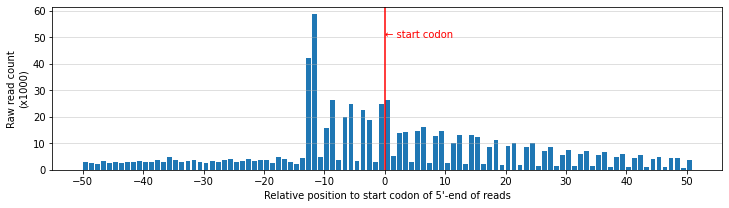

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12,3))

ax.bar(x, y, align="edge")
ax.axvline([0], c="red")
ax.text(0,50,"← start codon", c="red")
ax.grid(axis="y", alpha=.5)
plt.xticks(np.arange(-50,51,10))
plt.ylabel("Raw read count\n(x1000)")
plt.xlabel("Relative position to start codon of 5'-end of reads")